In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fhy37tnd because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75

# Intuitively determined:
batch_size = 100

train_batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)
        
train_inputs, train_targets = next(train_batch_generator)

switching to train_2.h5 and train_4.h5


In [3]:
OUTPUT_LEN = 20

encoder = tf.keras.Sequential([
    layers.Dense(2048, activation = 'relu'),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Activation('softmax'),
], name='encoder')


# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(kmeans.shape[0], activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')


X_pairs = layers.Input([2, 4096])

# Essentially, we started with a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:]))(X_pairs)

distances = layers.Lambda(lambda Xs: tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)))([X1,X2])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)

# Glue them back together! Back into a batch of feature vector pairs.
S_pairs = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2])

# Dimensions: (batch_size x 80 x 4 x 2 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 2 x DNA length x 4)
S_pairs_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_pairs)

# y_h: Estimated output
y_h = layers.Lambda(tf.function(log10_norm_crispr_spec))(S_pairs_T)
y_h_T = layers.Reshape([1])(y_h)
    
calcseq = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T)
calcdists = tf.keras.Model(inputs=X_pairs, outputs=distances)
encoder_trainer = tf.keras.Model(inputs=X_pairs, outputs=y_h_T)



In [4]:
encoder_trainer.compile(tf.keras.optimizers.Adagrad(1e-2), 'binary_crossentropy')
history = encoder_trainer.fit(train_inputs, train_targets, epochs=3)

Epoch 1/3
4/4 [==============================] - 1s 5ms/step - loss: 7.5582
Epoch 2/3
4/4 [==============================] - 0s 4ms/step - loss: 7.5582
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 7.5582


In [5]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    loss = tf.metrics.MSE(train_targets,pred)
    pred = encoder_trainer(train_inputs)
    

# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

NameError: name 'pred' is not defined

<IPython.core.display.Javascript object>


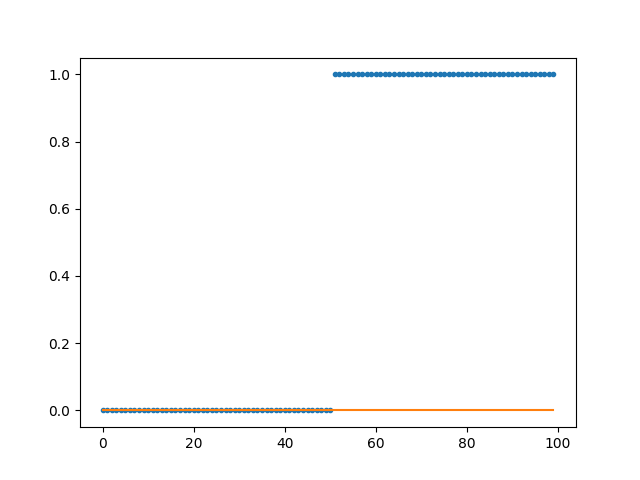

(100,)
(100,)


In [6]:


idx = train_targets.argsort()

Y = encoder_trainer.predict(train_inputs)
seqs = calcseq.predict(train_inputs)
plt.figure()

print(train_targets.shape)
print((Y[:, 0] - train_targets).shape)
plt.plot(train_targets[idx], '.')
plt.plot(Y[idx][:, 0])

In [7]:

all_seqs = np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])
#print(all_seqs)
seq_strings = seqtools.onehots_to_seqs(all_seqs)
np.unique(seq_strings)


array(['AAACTACTCTTAGACCAGAG', 'AACGCTGGCTGTAACGAGGC',
       'AAGCCAAAATGTAACAAGCT', 'AAGCCTGACAGCTGCAAGTC',
       'AAGCCTGTCAGAGGTGAAGT', 'AAGCTCGAATGAAATAGCAC',
       'AAGGCAGAAATAAGCAATTC', 'AAGGCCGTATGCGGCAACAC',
       'AAGTTAATATGATGTGACTC', 'AATCAACTTACAAGTGAGAG',
       'AATCATAAAACGAGAGAGAG', 'AATCATAACATCAGCGAGGC',
       'AATCATGTGCCGAGCGGGAC', 'AATCCAATCTCGAGGAAGAG',
       'AATCTTCTCTTATACAACTT', 'AATGCCATAACGAACCAGTC',
       'AATGTCCTCTCCGGCGAGGG', 'ACACTCGCATCCAGCTACGG',
       'ACGCTACAAACCGACAAGAC', 'ACTCACCAGTACATCAAAGT',
       'ACTCCCCAATGGAGTGAAAC', 'ACTCTAGCTAGCAGCAAGGG',
       'ACTGTACACTTACGCGGAGT', 'ACTTCTGAAAGAAACGAAGT',
       'AGGATACAAAGTTACAACAC', 'AGGCATCTAACACGCAAAGT',
       'AGGCTAAAATGCTGTGAATT', 'AGGCTCCAGTCATACAAGAT',
       'AGTCTAAAGTTAATCGACAG', 'AGTCTACCATCAAGCACAAG',
       'AGTTAAGTAATTTACGACAG', 'ATACCTGTAATTGACCAGGG',
       'ATGCACATCAGAAGTGCGTG', 'ATGCTAATGTCCACTGATAT',
       'ATGCTCACGAAAAGCTCAGT', 'ATGGTAAAACCAAATAAGAC',
       'AT

<IPython.core.display.Javascript object>


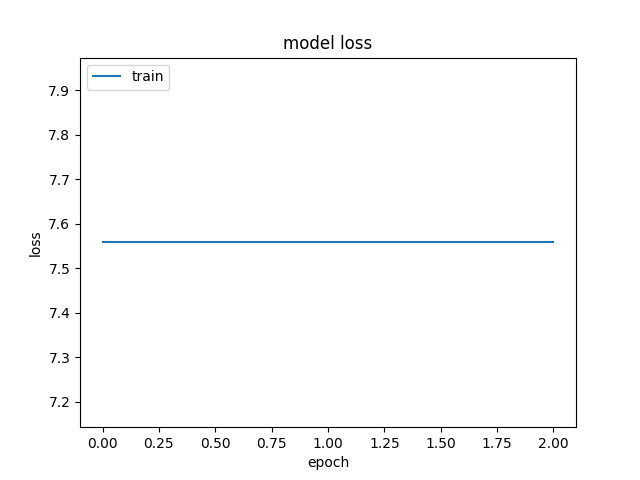

In [8]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [9]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [10]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

1.0

In [11]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

(1, 2, 20, 4)
linear: [0.0002]
log10norm: [-1.1920929e-07]


(20, 4)

In [12]:
print(np.around(all_seqs[0], 4))

[[0.1728 0.1783 0.3031 0.3457]
 [0.2529 0.3214 0.1485 0.2772]
 [0.2357 0.2929 0.2357 0.2357]
 [0.1884 0.1613 0.5036 0.1467]
 [0.1468 0.5338 0.2013 0.1181]
 [0.1978 0.2957 0.3086 0.1978]
 [0.0945 0.0575 0.0649 0.7831]
 [0.152  0.4606 0.2355 0.152 ]
 [0.3216 0.123  0.4325 0.123 ]
 [0.1971 0.555  0.1132 0.1346]
 [0.1905 0.1905 0.2459 0.3731]
 [0.1473 0.3252 0.1559 0.3715]
 [0.3082 0.1933 0.1933 0.3052]
 [0.7083 0.0275 0.1053 0.1589]
 [0.1259 0.1506 0.5763 0.1473]
 [0.2499 0.2503 0.2499 0.2499]
 [0.4715 0.1762 0.1762 0.1762]
 [0.2123 0.3066 0.2123 0.2688]
 [0.3873 0.2565 0.1776 0.1785]
 [0.0884 0.337  0.1805 0.3941]]
